In [17]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from cleantext import clean
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier,  PassiveAggressiveClassifier
from sklearn.preprocessing import LabelEncoder
import operator
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn import metrics

In [2]:
#Loading the FakeNewsCorpus into a pandas dataframe with 1.6 million rows ~ 3gb
df = pd.read_csv('news_cleaned_2018_02_13.csv', encoding='utf8', nrows=1_600_000, dtype={'content':'string', 'type':'string'}, usecols=['content', 'type'], lineterminator='\n', skip_blank_lines=True)

#Remove all empty rows from 'content' field
df = df.dropna(subset=['content'])
df = df.dropna(subset=['type'])
print("Content without empty content:", len(df.index))

#Remove both nan and unknown types
df = df[~df['type'].isin(['nan', 'unknown'])]
print("Content without Nan and unknown types:", len(df.index))

#Remove duplicate rows from 'content' field
df = df.drop_duplicates(subset=['content'])
print("Content without duplicate contents:", len(df.index))

#Save result in csv file named 'content_type_data'
df.to_csv('content_type_data.csv', columns=['content', 'type'])

Content without empty content: 1430252
Content without Nan and unknown types: 1377086
Content without duplicate contents: 932256


In [2]:
#Cleantext method, which utilises the clean method from cleantext as well as regex
def clean_data(input_text):
    cleaned_text = re.sub(r'(\S+\.com*\S+)', '<url>', input_text)
    cleaned_text = re.sub(r'(\S+\.net*\S+)', '<url>', cleaned_text)
    cleaned_text = re.sub(r'\-', ' ', cleaned_text)
    cleaned_text = re.sub(r'\|', ' ', cleaned_text)
    cleaned_text = clean(cleaned_text,  # does not remove special characters such as < , ^ etc.
        normalize_whitespace=True,
        fix_unicode=True,  # fix various unicode errors
        to_ascii=True,  # transliterate to closest ASCII representation
        lower=True,  # lowercase text
        no_line_breaks=True,  # fully strip line breaks as opposed to only normalizing them
        no_urls=True,  # replace all URLs with a special token
        no_emails=True,  # replace all email addresses with a special token
        no_phone_numbers=True,  # replace all phone numbers with a special token
        no_numbers=True,  # replace all numbers with a special token
        no_digits=True,  # replace all digits with a special token
        no_currency_symbols=True,  # replace all currency symbols with a special token
        no_punct=True,  # remove punctuations
        no_emoji=True,
        replace_with_punct="",  # instead of removing punctuations you may replace them
        replace_with_url="<URL>",
        replace_with_email="<EMAIL>",
        replace_with_phone_number="<PHONE>",
        replace_with_number="<NUMBER>",
        replace_with_digit="<DIGIT>",
        replace_with_currency_symbol="<CUR>",
        lang="en")

    return cleaned_text

In [3]:
#Reload the 'content_type_data' csv file into a pandas dataframe again
df = pd.read_csv('content_type_data.csv', encoding='utf8', dtype={'content':'string', 'type':'string'})
data_size = len(df.index)
pd.DataFrame(columns=['content', 'type']).to_csv("cleaned_text.csv")

#Cleans all the articles, and appends it to a new csv file 'cleaned_text'
for i in range(0, data_size):
    content_result = clean_data(df.iloc[i]['content'])
    type_result = df.iloc[i]['type']

    result = {'content':content_result, 'type':type_result}
    new_data = pd.DataFrame(result, index=[i])
    new_data.to_csv('cleaned_text.csv', mode='a', header=False)

In [4]:
#Load the 'cleaned_text' csv file into pandas dataframe, and replace the types to either fake or reliable
df_cleaned = pd.read_csv('cleaned_text.csv', encoding='utf8', dtype={'content':'string', 'type':'string'}).dropna(subset=['content'])
df_cleaned['type'] = df_cleaned['type'].replace(['unreliable', 'bias', 'junksci', 'conspiracy', 'hate', 'rumor', 'satire', 'state'], 'fake')
df_cleaned['type'] = df_cleaned['type'].replace(['political', 'clickbait'], 'reliable')
df_cleaned.columns = df_cleaned.columns.str.strip() #Removes unecessary \r from 'type' column
df_cleaned['type'] = df_cleaned['type'].replace('\r', '', regex=True) #Remove unecessary \r from types
df_cleaned.to_csv('cleaned_changed_types.csv', columns=['content', 'type'])

In [2]:
#Method to remove placeholder words using regex
def remove_placeholder_words(input_text):
    cleaned_text = re.sub(r'\<\w+\>', ' ', input_text)
    cleaned_text = re.sub(' +', ' ', cleaned_text)

    return cleaned_text

In [5]:
#Reload the 'cleaned_changed_types' csv file into a pandas dataframe again
df = pd.read_csv('cleaned_changed_types.csv', encoding='utf8', dtype={'content':'string', 'type':'string'})
data_size = len(df.index)
pd.DataFrame(columns=['content', 'type']).to_csv("cleaned_removed_placeholder.csv")

#Removes all the placeholder words, and appends it to a new csv file 'cleaned_removed_placeholder'
for i in range(0,data_size):
    content_result = remove_placeholder_words(df.iloc[i]['content'])
    type_result = df.iloc[i]['type']

    result = {'content':content_result, 'type':type_result}
    new_data = pd.DataFrame(result, index=[i])
    new_data.to_csv('cleaned_removed_placeholder.csv', mode='a', header=False)

In [ ]:
#Drops duplicates and \r from columns and types
df = pd.read_csv('cleaned_removed_placeholder.csv', encoding='utf8', dtype={'content':'string', 'type':'string'}).dropna(subset=['content'])
df.columns = df.columns.str.strip() #Removes unecessary \r from 'type' column
df['type'] = df['type'].replace('\r', '', regex=True) #Remove unecessary \r from types
df.to_csv('cleaned_removed_placeholder.csv', columns=['content', 'type'])

In [2]:
#Method to remove stop words
def remove_stop_words(input_text):
    stop_words = set(stopwords.words('english'))
    filtered_sentence = []
    cleaned_text = word_tokenize(input_text)

    for w in cleaned_text:
        if w not in stop_words:
            filtered_sentence.append(w)

    return ' '.join(filtered_sentence)

In [5]:
#Reload the 'cleaned_removed_placeholder' csv file into a pandas dataframe again
df = pd.read_csv('cleaned_removed_placeholder.csv', encoding='utf8', dtype={'content':'string', 'type':'string'}) #About as slow as clean text 1,5h
data_size = len(df.index)
pd.DataFrame(columns=['content', 'type']).to_csv("cleaned_removed_stop_words.csv")

#Removes the stop words from the articles
for i in range(0, data_size):
    content_result = remove_stop_words(df.iloc[i]['content'])
    type_result = df.iloc[i]['type']

    result = {'content':content_result, 'type':type_result}
    new_data = pd.DataFrame(result, index=[i])
    new_data.to_csv('cleaned_removed_stop_words.csv', mode='a', header=False)

In [ ]:
#Drops duplicates and \r from columns and types
df = pd.read_csv('cleaned_removed_stop_words.csv', encoding='utf8', dtype={'content':'string', 'type':'string'}).dropna(subset=['content'])
df.columns = df.columns.str.strip() #Removes unecessary \r from 'type' column
df['type'] = df['type'].replace('\r', '', regex=True) #Remove unecessary \r from types
df.to_csv('cleaned_removed_stop_words.csv', columns=['content', 'type'])

In [2]:
#Method to stem words
def stemming_words(input_text):
    ps = PorterStemmer()

    stemmed_words = []

    for word in word_tokenize(input_text):
        stemmed_words.append(ps.stem(word))

    return ' '.join(stemmed_words)

In [3]:
#Reload the 'cleaned_removed_stop_words' csv file into a pandas dataframe again
df = pd.read_csv('cleaned_removed_stop_words.csv', encoding='utf8', dtype={'content':'string', 'type':'string'}) #about as slow as clean text 1,5h
data_size = len(df.index)
pd.DataFrame(columns=['content', 'type']).to_csv("cleaned_stemmed.csv")

#Stems word from articles
for i in range(0, data_size):
    content_result = stemming_words(df.iloc[i]['content'])
    type_result = df.iloc[i]['type']

    result = {'content':content_result, 'type':type_result}
    new_data = pd.DataFrame(result, index=[i])
    new_data.to_csv('cleaned_stemmed.csv', mode='a', header=False)

In [ ]:
#Remove duplicates and \r
df = pd.read_csv('cleaned_stemmed.csv', encoding='utf8', dtype={'content':'string', 'type':'string'}).dropna(subset=['content'])
df.columns = df.columns.str.strip() #Removes unecessary \r from 'type' column
df['type'] = df['type'].replace('\r', '', regex=True) #Remove unecessary \r from types
df.to_csv('cleaned_stemmed.csv', columns=['content', 'type'])

Statistics

In [2]:
#Read the final csv file into pandas dataframe and count <url>, <email>... and so on
df = pd.read_csv('cleaned_changed_types.csv', encoding='utf8', dtype={'content':'string', 'type':'string'})
data_size = len(df.index)

placeholder_counter = [['<url>', 0], ['<email>', 0], ['<phone>', 0], ['<number>', 0], ['<digit>', 0], ['<cur>', 0]]

for i in range(0, data_size):
    current_text = df.iloc[i]['content']
    for j in range(0, len(placeholder_counter)-1):
        placeholder_counter[j][1] += len(re.findall(placeholder_counter[j][0], current_text))

print(placeholder_counter)

[['<url>', 401860], ['<email>', 4776], ['<phone>', 109366], ['<number>', 10196147], ['<digit>', 2133602], ['<cur>', 0]]


In [3]:
#Counts total amount of words in the different csv files
def total_word_counter(input_text, text_size):
    total_counter = 0
    for i in range(0, text_size):
        total_counter += len(re.findall(' ', input_text.iloc[i]['content']))+1

    return total_counter

df = pd.read_csv('cleaned_changed_types.csv', encoding='utf8', dtype={'content': 'string', 'type': 'string'}, lineterminator='\n')
data_size = len(df.index)
print("Total number of words after cleaning:", total_word_counter(df, data_size))
df = pd.read_csv('cleaned_removed_placeholder.csv', encoding='utf8', dtype={'content': 'string', 'type': 'string'}, lineterminator='\n')
data_size = len(df.index)
print("Total number of words after removing placeholders:", total_word_counter(df, data_size))
df = pd.read_csv('cleaned_removed_stop_words.csv', encoding='utf8', dtype={'content': 'string', 'type': 'string'}, lineterminator='\n')
data_size = len(df.index)
print("Total number of words after removing stopwords:", total_word_counter(df, data_size))
df = pd.read_csv('cleaned_stemmed.csv', encoding='utf8', dtype={'content': 'string', 'type': 'string'}, lineterminator='\n')
data_size = len(df.index)
print("Total number of words after stemming:", total_word_counter(df, data_size))

Total number of words after cleaning: 512028513
Total number of words after removing placeholders: 502279962
Total number of words after removing stopwords: 287382920
Total number of words after stemming: 287382920


In [4]:
#Counts amount of different types
df = pd.read_csv('content_type_data.csv', encoding='utf8', dtype={'content':'string', 'type':'string'})
type_list = df['type'].value_counts(dropna=True)
print(type_list)

political     271131
rumor         138543
bias          136809
fake          120177
conspiracy    107713
hate           42968
unreliable     39067
satire         28572
clickbait      23724
junksci        17665
reliable        5887
Name: type, dtype: Int64


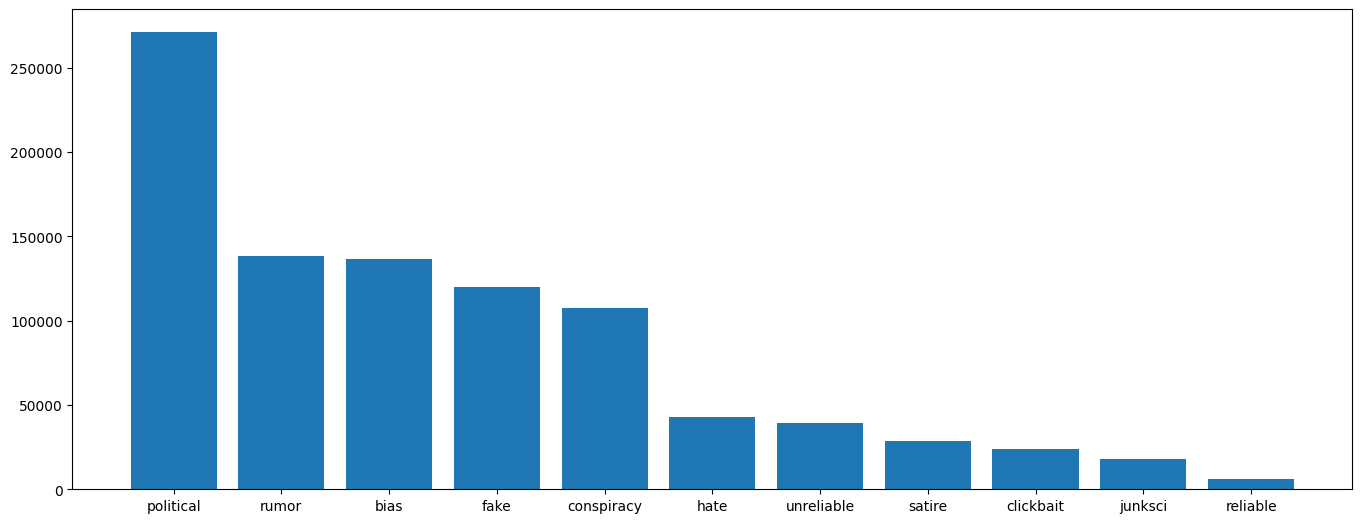

In [5]:
#plottting amount of different types
d = dict(type_list)

name_list = list(d.keys())
name_values = list(d.values())

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(list(name_list), list(name_values))
plt.show()

In [7]:
#Counts amount of fake and reliable types
df = pd.read_csv('cleaned_stemmed.csv', encoding='utf8', dtype={'content':'string', 'type':'string'})
type_list = df['type'].value_counts(dropna=True)
print(type_list)
print(len(df.index))

fake        629015
reliable    300741
Name: type, dtype: Int64
929756


In [8]:
#Counting words before stop and stem
data_size = 100000
df = pd.read_csv('cleaned_changed_types.csv', encoding='utf8', nrows=data_size, dtype={'content':'string', 'type':'string'})

counts = dict()
for i in range(0, data_size-1):
    words = word_tokenize(df.iloc[i]['content'])

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

sorted_list= sorted(counts.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_list[0:100])

[('the', 3620849), ('of', 1765584), ('to', 1747743), ('>', 1655530), ('<', 1648730), ('and', 1647538), ('a', 1293775), ('number', 1256726), ('in', 1177566), ('that', 809503), ('is', 777258), ('for', 599681), ('on', 480356), ('it', 444577), ('as', 402569), ('are', 399380), ('this', 393315), ('with', 390280), ('by', 328304), ('be', 327366), ('was', 323325), ('i', 314127), ('have', 294932), ('you', 291949), ('not', 291324), ('from', 275379), ('at', 263406), ('digit', 240903), ('he', 233062), ('they', 230941), ('we', 229491), ('but', 226207), ('has', 225617), ('or', 223807), ('an', 217466), ('his', 200019), ('will', 197488), ('their', 190004), ('all', 181030), ('its', 174714), ('who', 173780), ('more', 165041), ('about', 161656), ('us', 161195), ('one', 157972), ('can', 147928), ('if', 147790), ('what', 141692), ('were', 138496), ('so', 135376), ('our', 134629), ('which', 133456), ('would', 133415), ('been', 130153), ('people', 129191), ('your', 128260), ('out', 126080), ('trump', 125254),

In [9]:
#Counting words after stop and stem
data_size = 100000
df = pd.read_csv('cleaned_stemmed.csv', encoding='utf8', nrows=data_size, dtype={'content':'string', 'type':'string'})


counts = dict()
for i in range(0, data_size-1):
    words = word_tokenize(df.iloc[i]['content'])

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

sorted_list= sorted(counts.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_list[0:100])

[('one', 168240), ('us', 161215), ('state', 148568), ('trump', 145098), ('peopl', 134932), ('year', 133840), ('would', 133444), ('time', 129654), ('like', 119956), ('new', 108326), ('said', 107733), ('use', 99572), ('also', 98566), ('report', 92849), ('make', 91494), ('get', 88026), ('presid', 86668), ('american', 84879), ('even', 83001), ('go', 82130), ('say', 81477), ('govern', 81401), ('blockchain', 79856), ('right', 79438), ('two', 78339), ('nation', 73582), ('work', 73581), ('mani', 73446), ('world', 72714), ('day', 72190), ('first', 71610), ('think', 70712), ('next', 67439), ('could', 67116), ('take', 66194), ('know', 65241), ('may', 64646), ('way', 64545), ('come', 64034), ('need', 64020), ('obama', 63957), ('call', 63297), ('well', 62926), ('see', 61797), ('market', 60989), ('want', 60274), ('countri', 56945), ('democrat', 56517), ('includ', 55471), ('support', 54652), ('republican', 54507), ('back', 53512), ('thing', 53113), ('news', 53071), ('last', 53035), ('polit', 52951), 

In [4]:
df = pd.read_csv('news_cleaned_2018_02_13.csv', nrows=0, encoding='utf8')
print("headers: ", df.columns.values)
print("amount of headers: ", len(df.columns.values))

headers:  ['Unnamed: 0' 'id' 'domain' 'type' 'url' 'content' 'scraped_at'
 'inserted_at' 'updated_at' 'title' 'authors' 'keywords' 'meta_keywords'
 'meta_description' 'tags' 'summary' 'source']
amount of headers:  17


In [3]:
df = pd.read_csv('news_cleaned_2018_02_13.csv', nrows=1_600_000, encoding='utf8', dtype={'Unnamed: 0': 'string', 'id': 'string', 'domain': 'string', 'type': 'string', 'url': 'string', 'content': 'string', 'scraped_at': 'string', 'inserted_at': 'string', 'updated_at': 'string', 'title': 'string', 'authors': 'string', 'keywords': 'string', 'meta_keywords': 'string','meta_description': 'string', 'tags': 'string', 'summary': 'string', 'source': 'string',}, lineterminator='\n')

colum_names = df.columns.values
for i in range(0, len(colum_names)):
    nan_count = df[str(colum_names[i])].isna().sum()
    print("Number of NAN in colum " + str(colum_names[i]) + ":", nan_count)

Number of NAN in colum Unnamed: 0 : 0
Number of NAN in colum id : 0
Number of NAN in colum domain : 0
Number of NAN in colum type : 169748
Number of NAN in colum url : 0
Number of NAN in colum content : 0
Number of NAN in colum scraped_at : 0
Number of NAN in colum inserted_at : 0
Number of NAN in colum updated_at : 0
Number of NAN in colum title : 15678
Number of NAN in colum authors : 703210
Number of NAN in colum keywords : 1600000
Number of NAN in colum meta_keywords : 0
Number of NAN in colum meta_description : 948698
Number of NAN in colum tags : 963113
Number of NAN in colum summary : 1600000
Number of NAN in colum source : 1600000


Prediction modelling

In [2]:
#Read the 'cleaned_stemmed' into a pandas dataframe, and remove unecessary \r that may have come with
df = pd.read_csv('cleaned_stemmed.csv', encoding='utf8', lineterminator='\n', dtype={'content':'string', 'type':'string'})
df.columns = df.columns.str.strip() #Remove unecessary \r
df['type'] = df['type'].replace('\r', '', regex=True) #Remove unecessary r from types

In [3]:
#Method to convert text to numeric, so we can fit this into our data using TF-IDF Weights
X = df['content']

y = df['type']
encoder = LabelEncoder() #Good for binary use, and sets fake as 0 and reliable as 1
y = encoder.fit_transform(y)

#Split the training, validation and test data into 80%/10%/10% and stratify to be more balanced
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0, stratify=y_test)

#Create TF-IDF converter object
vectorizer = TfidfVectorizer()

#Fit transform on the training data
X_train = vectorizer.fit_transform(X_train)

#Only transform on the validation and test data
X_val = vectorizer.transform(X_val)

X_test = vectorizer.transform(X_test)

In [4]:
#Baseline model, create Decision Tree (this has been hyperparameter optimised!)
ds = DecisionTreeClassifier(min_samples_split = 2, min_samples_leaf = 1, max_features = None, max_depth= 20, criterion= 'gini')

#Fit the training data on the Decision tree
ds.fit(X_train, y_train)

#Create predictions on training, testing and validation
y_pred_ds_test = ds.predict(X_test)
y_pred_ds_train = ds.predict(X_train)
y_pred_ds_val = ds.predict(X_val)

#Print the accuracy as well as MSE
print("Test accuracy score for DS:", accuracy_score(y_test, y_pred_ds_test))
print("Train accuracy score for DS:", accuracy_score(y_train, y_pred_ds_train))
print("Val accuracy score for DS:", accuracy_score(y_val, y_pred_ds_val))
print("Test MSE for DS:", mean_squared_error(y_test, y_pred_ds_test))
print("F1-score for DS:", f1_score(y_test, y_pred_ds_test, average="weighted"))

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
#The hyperparameter setup, outcommented as it isn't necessary anymore

# param_grid_tree = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 5, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None]
# }

# best_tree = RandomizedSearchCV(estimator=ds, param_distributions=param_grid_tree, n_iter=10, cv=5, scoring='accuracy', random_state = 0)

# best_tree.fit(X_train, y_train)

# print('Best Params', best_tree.best_params_)
# print('Best Score:', best_tree.best_score_)

Test accuracy score for DS: 0.8025511960075719
Train accuracy score for DS: 0.8172717543869084
Val accuracy score for DS: 0.8026479951815523
Test MSE for DS: 0.19744880399242815
F1-score for DS: 0.7964669227135054


In [5]:
#Baseline model, create Logistic Regression (which has not been hyperparameter optimised!)
logr = LogisticRegression(max_iter=1000, random_state=0)

#Fit the training data on LogR
logr.fit(X_train, y_train)

#Create predictions on training, testing and validation
y_pred_logr_test = logr.predict(X_test)
y_pred_logr_train = logr.predict(X_train)
y_pred_logr_val = logr.predict(X_val)

# evaluate the model using accuracy score
print("Test accuracy score for LogR:", accuracy_score(y_test, y_pred_logr_test))
print("Train accuracy score for LogR:", accuracy_score(y_train, y_pred_logr_train ))
print("Val accuracy score for LogR:", accuracy_score(y_val, y_pred_logr_val))
print("Test MSE for LogR:", mean_squared_error(y_test, y_pred_logr_test))
print("F1-score for LogR:", f1_score(y_test, y_pred_logr_test, average="weighted"))

Test accuracy score for LogR: 0.8701385303734297
Train accuracy score for LogR: 0.8862428811891304
Val accuracy score for LogR: 0.8702138186198589
Test MSE for LogR: 0.1298614696265703
F1-score for LogR: 0.8689121628754988


In [6]:
#Create Multinomial Naive Bayes (which has not been hyperparameter optimised!)
mnb = MultinomialNB()

#Fit the training data on MNB
mnb.fit(X_train, y_train)

#Create predictions on training, testing and validation
y_pred_mnb_test = mnb.predict(X_test)
y_pred_mnb_train = mnb.predict(X_train)
y_pred_mnb_val = mnb.predict(X_val)

#Print the accuracy as well as MSE
print("Test accuracy score for MNB:", accuracy_score(y_test, y_pred_mnb_test))
print("Train accuracy score for MNB:", accuracy_score(y_train, y_pred_mnb_train ))
print("Val accuracy score for MNB:", accuracy_score(y_val, y_pred_mnb_val))
print("Test MSE for MNB:", mean_squared_error(y_test, y_pred_mnb_test))
print("F1-score for MNB:", f1_score(y_test, y_pred_mnb_test, average="weighted"))

Test accuracy score for MNB: 0.7802120977456548
Train accuracy score for MNB: 0.7879602691031509
Val accuracy score for MNB: 0.7792871278609533
Test MSE for MNB: 0.21978790225434522
F1-score for MNB: 0.7498962804607276


In [7]:
#Create Bernoulli Naive Bayes (which has not been hyperparameter optimised!)
bnb = BernoulliNB()

#Fit the training data on BNB
bnb.fit(X_train, y_train)

#Create predictions on training, testing and validation
y_pred_bnb_test = bnb.predict(X_test)
y_pred_bnb_train = bnb.predict(X_train)
y_pred_bnb_val = bnb.predict(X_val)

#Print the accuracy as well as MSE
print("Test accuracy score for BNB:", accuracy_score(y_test, y_pred_bnb_test))
print("Train accuracy score for BNB:", accuracy_score(y_train, y_pred_bnb_train))
print("Val accuracy score for BNB:", accuracy_score(y_val, y_pred_bnb_val))
print("Test MSE for BNB:", mean_squared_error(y_test, y_pred_bnb_test))
print("F1-score for BNB:", f1_score(y_test, y_pred_bnb_test, average="weighted"))

Test accuracy score for BNB: 0.7442673378076062
Train accuracy score for BNB: 0.7501384773408049
Val accuracy score for BNB: 0.7428153501979006
Test MSE for BNB: 0.2557326621923937
F1-score for BNB: 0.7434000037171719


In [8]:
#Create Stochatic Gradient Descent (which has not been hyperparameter optimised!)
sgd = SGDClassifier(random_state=0)

#Fit the training data on SGD
sgd.fit(X_train, y_train)

#Create predictions on training, testing and validation
y_pred_sgd_test = sgd.predict(X_test)
y_pred_sgd_train = sgd.predict(X_train)
y_pred_sgd_val = sgd.predict(X_val)

#Print the accuracy as well as MSE
print("Test accuracy score for SGD:", accuracy_score(y_test, y_pred_sgd_test))
print("Train accuracy score for SGD:", accuracy_score(y_train, y_pred_sgd_train))
print("Val accuracy score for SGD:", accuracy_score(y_val, y_pred_sgd_val))
print("Test MSE for SGD:", mean_squared_error(y_test, y_pred_sgd_test))
print("F1-score for SGD:", f1_score(y_test, y_pred_sgd_test, average="weighted"))

Test accuracy score for SGD: 0.8196738943383238
Train accuracy score for SGD: 0.8207269657060193
Val accuracy score for SGD: 0.8198352262949579
Test MSE for SGD: 0.18032610566167614
F1-score for SGD: 0.8093690250523211


In [23]:
#Create PassiveAggressive (which has not been hyperparameter optimised!)
pac = PassiveAggressiveClassifier(random_state=0, C = 0.01, max_iter = 1000, shuffle=True, loss='squared_hinge', tol = 1e-3)

#Fit the training data on PAC
pac.fit(X_train, y_train)

#Create predictions on training, testing and validation
y_pred_pac_test = pac.predict(X_test)
y_pred_pac_train = pac.predict(X_train)
y_pred_pac_val = pac.predict(X_val)

#Print the accuracy as well as MSE
print("Test accuracy score for PAC:", accuracy_score(y_test, y_pred_pac_test))
print("Train accuracy score for PAC:", accuracy_score(y_train, y_pred_pac_train))
print("Val accuracy score for PAC:", accuracy_score(y_val, y_pred_pac_val))
print("Test MSE for PAC:", mean_squared_error(y_test, y_pred_pac_test))
print("F1-score for PAC:", f1_score(y_test, y_pred_pac_test, average="weighted"))

Test accuracy score for PAC: 0.8774845121321632
Train accuracy score for PAC: 0.9153782448064275
Val accuracy score for PAC: 0.8762153674066425
Test MSE for PAC: 0.12251548786783686
F1-score for PAC: 0.8770734997830381


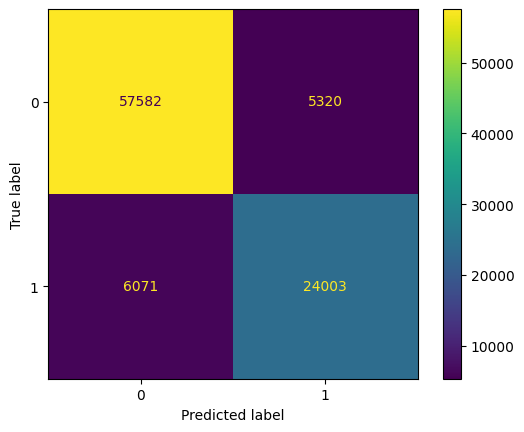

In [32]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_pac_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [12]:
#Create LSVM model (Which has been hyperparameter optimised!)
linear_svm = LinearSVC()

#Fit the training data on LSVM
linear_svm.fit(X_train, y_train)

#Create predictions on training, testing and validation
y_pred_svm_test = linear_svm.predict(X_test)
y_pred_svm_train = linear_svm.predict(X_train)
y_pred_svm_val = linear_svm.predict(X_val)

#Print the accuracy as well as MSE
print("Test accuracy score for LSVM:", accuracy_score(y_test, y_pred_svm_test))
print("Train accuracy score for LSVM:", accuracy_score(y_train, y_pred_svm_train))
print("Val accuracy score for LSVM:", accuracy_score(y_val, y_pred_svm_val))
print("Test MSE for LSVM:", mean_squared_error(y_test, y_pred_svm_test))
print("F1-score for LSVM:", f1_score(y_test, y_pred_svm_test, average="weighted"))


Test accuracy score for LSVM: 0.8785815694372742
Train accuracy score for LSVM: 0.9232647310312931
Val accuracy score for LSVM: 0.8764412321459302
Test MSE for LSVM: 0.12141843056272586
F1-score for LSVM: 0.878226517074656


Below is code to check the accuracy and f1 score of our baseline and advanced models on the LIAR Dataset

In [30]:
#Loading the LIAR dataset using pandas
df_liar = pd.read_csv('test.tsv', delimiter='\t', header=None)

#Content is in column 2, so we extract that and do some preprocessing using TF-IDF weights
X_liar = df_liar[2]
vectorizer_liar = TfidfVectorizer()
X_liar = vectorizer.transform(X_liar)

#Labels is in column 1, and we map each label to either 0 or 1, depending on
#If that label is false or true respectively
y_liar = df_liar[1].map({'false': 0, 'pants-fire': 0, 'barely-true': 0, 'half-true': 1, 'mostly-true': 1, 'true': 1})

#y_pred_liar_tree = ds.predict(X_liar) #Prediction on the baseline model, decisiontree
#y_pred_liar_logr = logr.predict(X_liar)
#y_pred_liar_LSVM = linear_svm.predict(X_liar)
#y_pred_liar_SGD = sgd.predict(X_liar)
y_pred_liar_PAC = pac.predict(X_liar)
#y_pred_liar_MNB = mnb.predict(X_liar)
#y_pred_liar_BNB = bnb.predict(X_liar)

#First we get the accuracy using accuracy score
#print("Accuracy score for DT", accuracy_score(y_liar, y_pred_liar_tree))
#print("Accuracy score for LogR", accuracy_score(y_liar, y_pred_liar_logr))
#print("Accuracy score for SGD", accuracy_score(y_liar, y_pred_liar_SGD))
print("Accuracy score for PAC", accuracy_score(y_liar, y_pred_liar_PAC))
#print("Accuracy score for MNB", accuracy_score(y_liar, y_pred_liar_MNB))
#print("Accuracy score for BNB", accuracy_score(y_liar, y_pred_liar_BNB))
#print("Accuracy score for LSVM", accuracy_score(y_liar, y_pred_liar_LSVM))

#And then we get the F1-score
#print("F1-score for DT", f1_score(y_liar, y_pred_liar_tree, average='weighted'))
#print("F1-score for LogR", f1_score(y_liar, y_pred_liar_logr, average='weighted'))
#print("F1-score for SGD", f1_score(y_liar, y_pred_liar_SGD, average='weighted'))
print("F1-score for PAC", f1_score(y_liar, y_pred_liar_PAC, average='weighted'))
#print("F1-score for MNB", f1_score(y_liar, y_pred_liar_MNB, average='weighted'))
#print("F1-score for BNB", f1_score(y_liar, y_pred_liar_BNB, average='weighted'))
#print("F1-score for LSVM", f1_score(y_liar, y_pred_liar_LSVM, average='weighted'))

Accuracy score for PAC 0.430939226519337
F1-score for PAC 0.28859442597320467


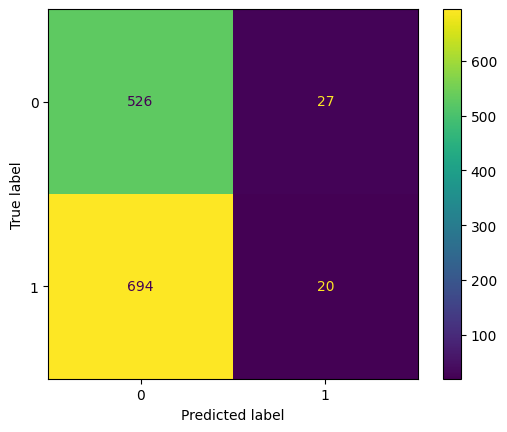

In [31]:
confusion_matrix = metrics.confusion_matrix(y_liar, y_pred_liar_PAC)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()